In [4]:
import os
import numpy as np
import pandas as pd
import sys
import importlib.util
import psutil

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    fbeta_score,
    average_precision_score,
    confusion_matrix
)
from sklearn.impute import SimpleImputer
from imblearn.ensemble import BalancedRandomForestClassifier

# Définir les chemins
PROJECT_PATH = '/content/drive/MyDrive/Projet'
SRC_PATH = os.path.join(PROJECT_PATH, "src")
sys.path.insert(0, SRC_PATH)

def print_memory_usage():
    process = psutil.Process()
    print(f"RAM utilisée: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def reduce_memory_usage(df):
    """ Itère sur les colonnes pour réduire la taille en mémoire """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Mémoire avant optimisation: {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                # On passe tout ce qui est float64 en float32 (division par 2 de la RAM)
                df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Mémoire après optimisation: {end_mem:.2f} MB')
    print(f'Gain: {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

def main():
    original_cwd = os.getcwd()
    original_sys_path = list(sys.path)

    try:
        print("Chemin du projet :", PROJECT_PATH)
        if os.getcwd() != SRC_PATH:
            os.chdir(SRC_PATH)

        # Chargement dynamique des modules
        spec_explore = importlib.util.spec_from_file_location("explore_data", os.path.join(SRC_PATH, 'explore_data.py'))
        explore_data = importlib.util.module_from_spec(spec_explore)
        spec_explore.loader.exec_module(explore_data)

        spec_preprocess = importlib.util.spec_from_file_location("preprocess", os.path.join(SRC_PATH, 'preprocess.py'))
        preprocess = importlib.util.module_from_spec(spec_preprocess)
        spec_preprocess.loader.exec_module(preprocess)
        from preprocess import process_and_save_all, load_processed_data

        print("Chargement des données (Tentative FM12 à FM48)...")
        # ON ESSAIE DE CHARGER PLUS DE DONNÉES GRÂCE À L'OPTIMISATION
        try:
            windows_to_load = ["FM12", "FM24", "FM36", "FM48", "FM60"]
            data = load_processed_data(PROJECT_PATH, windows=windows_to_load)

            if data.empty:
                print("Données vides. Génération...")
                process_and_save_all(PROJECT_PATH)
                data = load_processed_data(PROJECT_PATH, windows=windows_to_load)
        except Exception as e:
            print(f"Erreur chargement étendu: {str(e)}")
            print("Repli sur FM12/FM24...")
            data = load_processed_data(PROJECT_PATH, windows=["FM12", "FM24"])

        if not data.empty:
            print(f"\nDonnées brutes: {len(data)} lignes")

            # --- OPTIMISATION MÉMOIRE IMMÉDIATE ---
            data = reduce_memory_usage(data)
            # ---------------------------------------

            print("Nettoyage...")
            for col in ['CLoan_to_value', 'OLoan_to_value']:
                data[col] = pd.to_numeric(data[col].replace('**', np.nan), errors='coerce').astype(np.float32)

            X = data.drop(['DFlag', 'Origination_date'], axis=1)
            y = data['DFlag']

            print("Division Train/Test...")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            del data, X, y
            import gc
            gc.collect()

            print("Imputation...")
            # copy=False pour essayer de modifier sur place et sauver de la RAM
            imputer = SimpleImputer(missing_values=np.nan, strategy='median') # copy=False retiré car déprécié parfois, mais float32 aide
            X_train_imputed = imputer.fit_transform(X_train)
            X_test_imputed = imputer.transform(X_test)

            print("\nEntraînement Balanced Random Forest (n_estimators=100)...")
            model = BalancedRandomForestClassifier(
                n_estimators=100,
                sampling_strategy="all",
                replacement=True,
                max_depth=12,       # Légèrement réduit pour la sûreté RAM avec plus de données
                class_weight="balanced_subsample",
                random_state=42,
                n_jobs=-1,
                bootstrap=True
            )

            model.fit(X_train_imputed, y_train)

            # --- ANALYSE DE L'IMPORTANCE DES FEATURES ---
            print("\nImportance des variables (Top 10) :")
            importances = model.feature_importances_
            feature_names = X_train.columns
            indices = np.argsort(importances)[::-1]
            for f in range(min(10, len(feature_names))):
                print(f"{f+1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")
            # ---------------------------------------------

            print("\nGénération des probabilités...")
            y_prob = model.predict_proba(X_test_imputed)[:, 1]

            print("Optimisation du seuil...")
            best_threshold = 0.5
            best_f2 = 0.0
            thresholds = np.arange(0.50, 0.99, 0.01) # On scanne surtout la partie haute vu ton résultat précédent

            for thresh in thresholds:
                y_pred_thresh = (y_prob >= thresh).astype(int)
                score = fbeta_score(y_test, y_pred_thresh, beta=2.0)
                if score > best_f2:
                    best_f2 = score
                    best_threshold = thresh

            print(f"Meilleur seuil : {best_threshold:.2f}")

            y_pred_opt = (y_prob >= best_threshold).astype(int)

            acc = accuracy_score(y_test, y_pred_opt)
            prec = precision_score(y_test, y_pred_opt)
            rec = recall_score(y_test, y_pred_opt)
            f2 = fbeta_score(y_test, y_pred_opt, beta=2.0)
            roc_auc = roc_auc_score(y_test, y_prob)
            gini = 2 * roc_auc - 1
            pr_auc = average_precision_score(y_test, y_prob)

            print("\n" + "="*40)
            print(" RÉSULTATS FINAUX (Optimized RAM + More Data)")
            print("="*40)
            print(f"{'Accuracy':<15} : {acc:.4f}")
            print(f"{'Precision':<15} : {prec:.4f}")
            print(f"{'Recall':<15} : {rec:.4f}")
            print(f"{'F2-Score':<15} : {f2:.4f}")
            print("-"*40)
            print(f"{'ROC AUC':<15} : {roc_auc:.4f}")
            print(f"{'GINI':<15} : {gini:.4f}")
            print(f"{'PR-AUC':<15} : {pr_auc:.4f}")
            print("="*40)
            print(confusion_matrix(y_test, y_pred_opt))

        else:
            print("Dataset vide.")

    except Exception as e:
        print(f"\nERREUR CRITIQUE : {str(e)}")
        print_memory_usage()

    finally:
        if os.getcwd() != original_cwd:
             os.chdir(original_cwd)
        sys.path = original_sys_path

if __name__ == "__main__":
    main()

Chemin du projet : /content/drive/MyDrive/Projet
Chargement des données (Tentative FM12 à FM48)...
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM24/green/OOU_24.csv


/content/drive/MyDrive/Projet/src/preprocess.py:98: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM24/red/OOU_24.csv
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM36/green/OOU_36.csv
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM36/red/OOU_36.csv
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM48/green/OOU_48.csv
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM48/red/OOU_48.csv


/content/drive/MyDrive/Projet/src/preprocess.py:98: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/content/drive/MyDrive/Projet/src/preprocess.py:98: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM60/green/OOU_60.csv
Fichier introuvable : /content/drive/MyDrive/Projet/data/processed/FM60/red/OOU_60.csv

Données brutes: 17339223 lignes
Mémoire avant optimisation: 3439.48 MB
Mémoire après optimisation: 1918.17 MB
Gain: 44.2%
Nettoyage...
Division Train/Test...
Imputation...

Entraînement Balanced Random Forest (n_estimators=100)...

Importance des variables (Top 10) :
1. Credit_Score: 0.4632
2. Debt_to_income: 0.1974
3. CLoan_to_value: 0.0915
4. Single_borrower: 0.0865
5. OLoan_to_value: 0.0714
6. Mortgage_Insurance: 0.0171
7. is_Loan_purpose_purc: 0.0116
8. is_Loan_purpose_noca: 0.0095
9. is_Loan_purpose_cash: 0.0077
10. is_Origination_channel_reta: 0.0067

Génération des probabilités...
Optimisation du seuil...
Meilleur seuil : 0.68

 RÉSULTATS FINAUX (Optimized RAM + More Data)
Accuracy        : 0.8942
Precision       : 0.0578
Recall          : 0.4006
F2-Score        : 0.1832
----------------------------------

1. Chargement...
2. Nettoyage...
3. Segmentation...
4. Calcul t-SNE en cours...
[2025-11-27 09:24:12.041] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


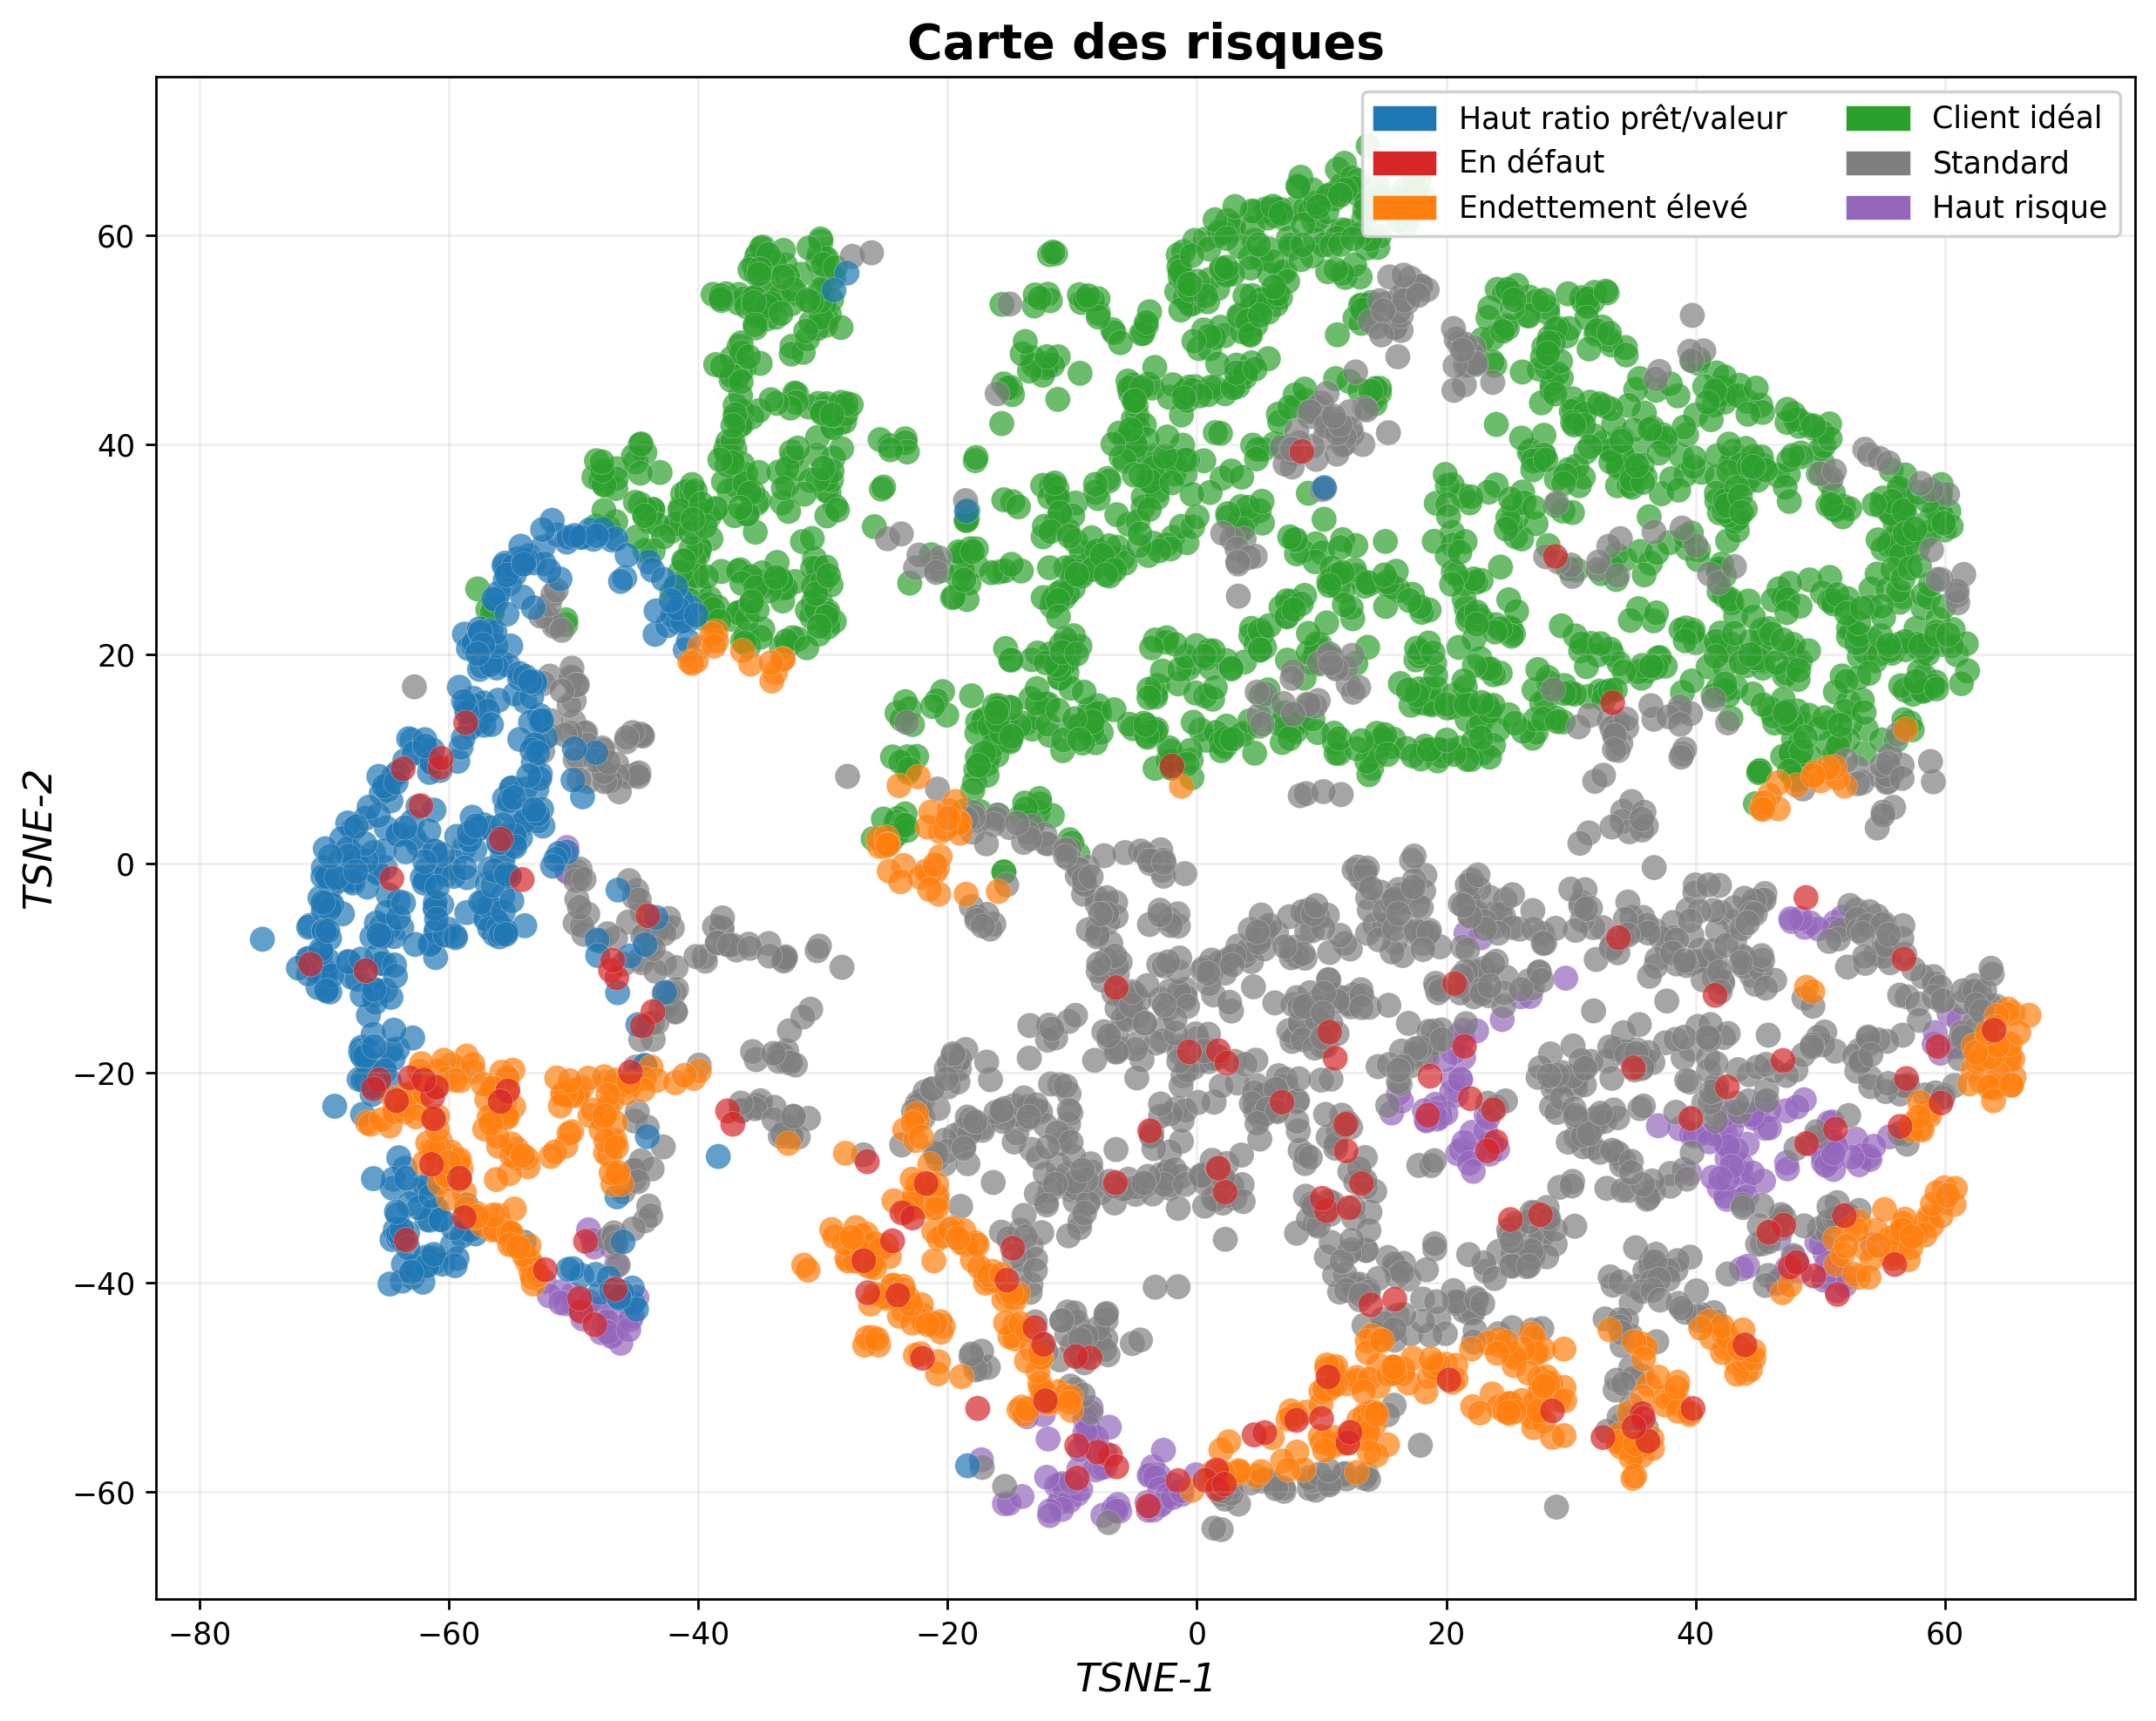

In [139]:
# ==============================================================================
# VISUALISATION t-SNE FINALE (Légende FRANÇAISE avec Ordre Personnalisé 2x3)
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib.patches import Rectangle
from sklearn.manifold import TSNE

# --- 1. CONFIGURATION DES CHEMINS ---
try:
    if 'PROJECT_PATH' not in globals():
        PROJECT_PATH = '/content/drive/MyDrive/Projet'

    BASE_PATH = os.path.join(PROJECT_PATH, "data", "processed", "FM12")
    FILE_GREEN = os.path.join(BASE_PATH, 'green', 'train_12.csv')
    FILE_RED = os.path.join(BASE_PATH, 'red', 'OOU_12.csv')

except NameError:
    FILE_GREEN = 'train_12.csv'
    FILE_RED = 'OOU_12.csv'

# --- 2. FONCTIONS (inchangées) ---

def load_and_sample_data(green_path, red_path, n_samples=5000):
    if not os.path.exists(green_path) or not os.path.exists(red_path):
        raise FileNotFoundError(f"Fichiers introuvables : {green_path}")

    cols_req = ['Credit_Score', 'Debt_to_income', 'CLoan_to_value', 'OLoan_to_value', 'DFlag']

    try:
        df_green = pd.read_csv(green_path, usecols=lambda c: c in cols_req)
        df_red = pd.read_csv(red_path, usecols=lambda c: c in cols_req)
    except ValueError as e:
        print(f"Erreur colonnes: {e}")
        raise e

    df = pd.concat([
        df_green.sample(n=min(len(df_green), n_samples // 2), random_state=42),
        df_red.sample(n=min(len(df_red), n_samples // 2), random_state=42)
    ], axis=0).reset_index(drop=True)

    return df

def clean_data_tsne(df):
    df = df.copy()
    cols_numeric = ['Credit_Score', 'Debt_to_income', 'CLoan_to_value', 'OLoan_to_value']

    for col in cols_numeric:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d\.-]', '', regex=True), errors='coerce')

    imputer = SimpleImputer(strategy='median')
    df[cols_numeric] = imputer.fit_transform(df[cols_numeric])
    return df

def create_risk_clusters(row):
    try:
        dflag = int(row['DFlag'])
        score = float(row['Credit_Score'])
        dti = float(row['Debt_to_income'])
        ltv = float(row['CLoan_to_value'])

        if dflag == 1: return "Default"
        if score >= 760: return "Super Prime"
        elif score < 660: return "Subprime"
        if dti > 43: return "High Debt"

        if (ltv > 0.90 and ltv < 2.0) or (ltv > 90):
            return "High Leverage"

        return "Standard"
    except:
        return "Standard"

# --- 3. EXÉCUTION ---
try:
    print("1. Chargement...")
    df_viz = load_and_sample_data(FILE_GREEN, FILE_RED, n_samples=5000)

    print("2. Nettoyage...")
    df_viz = clean_data_tsne(df_viz)

    print("3. Segmentation...")
    df_viz['Cluster_Label'] = df_viz.apply(create_risk_clusters, axis=1)

    print("4. Calcul t-SNE en cours...")
    features = ['Credit_Score', 'Debt_to_income', 'CLoan_to_value', 'OLoan_to_value']
    X = StandardScaler().fit_transform(df_viz[features])

    # --- BLOC CUML OPTIMISÉ (avec fallback) ---
    try:
        from cuml.manifold import TSNE as TSNE_CUML
        tsne = TSNE_CUML(n_components=2, perplexity=44, n_neighbors=150, early_exaggeration=80.0,
                         n_iter=5000, learning_rate=8000.0, init='pca', random_state=42)
    except ImportError:
        tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init='pca', learning_rate='auto', random_state=42)

    res = tsne.fit_transform(X)
    df_viz['x'] = res[:,0]
    df_viz['y'] = res[:,1]

    # 3. Paramètres de couleurs
    colors_map = {
        "Default": "#d62728",      # Rouge
        "Super Prime": "#2ca02c",  # Vert
        "High Debt": "#ff7f0e",    # Orange
        "Subprime": "#9467bd",     # Mauve
        "High Leverage": "#1f77b4",# Bleu
        "Standard": "#7f7f7f"      # Gris
    }

    # --- DICTIONNAIRE DE TRADUCTION ---
    FRENCH_MAP = {
        "High Leverage": "Haut ratio prêt/valeur",
        "Super Prime": "Client idéal",
        "Default": "En défaut",
        "High Debt": "Endettement élevé",
        "Subprime": "Haut risque",
        "Standard": "Standard"
    }

    # --- NOUVEL ORDRE TECHNIQUE (pour un affichage Ligne par Ligne) ---
    # [HL, SP, Def, Std, HD, SB]
    tech_order_keys = [
        "High Leverage", "Default", "High Debt",   # Colonne GAUCHE
        "Super Prime",   "Standard", "Subprime"  # Colonne DROITE
    ]

    # 4. Préparation des labels et handles finaux
    custom_handles = [Rectangle((0, 0), 1, 1, color=colors_map[label]) for label in tech_order_keys]
    french_labels = [FRENCH_MAP[label] for label in tech_order_keys]

    # 5. Génération du graphique
    plt.figure(figsize=(10, 8))

    sns.scatterplot(
        data=df_viz.sort_values('Cluster_Label', ascending=False),
        x='x', y='y', hue='Cluster_Label', palette=colors_map,
        alpha=0.7, s=70, edgecolor='white', linewidth=0.1, legend=False
    )

    # Verrouillage des limites
    x_min, x_max = df_viz['x'].min(), df_viz['x'].max()
    y_min, y_max = df_viz['y'].min(), df_viz['y'].max()
    x_buffer = (x_max - x_min) * 0.06
    y_buffer = (y_max - y_min) * 0.05
    plt.xlim(x_min - x_buffer, x_max + x_buffer)
    plt.ylim(y_min - y_buffer, y_max + y_buffer)

    plt.xlabel('TSNE-1', fontsize=13, fontstyle='italic', fontweight="light")
    plt.ylabel('TSNE-2', fontsize=13, fontstyle='italic', fontweight="light")

    # Ajout des lettres (A, B, C...)
    # letter_mapping = {
    #     "Super Prime": "A", "High Debt": "B", "Subprime": "C",
    #     "High Leverage": "D", "Default": "F", "Standard": "E"
    # }

    # for label_long, letter_short in letter_mapping.items():
    #     subset = df_viz[df_viz['Cluster_Label'] == label_long]
    #     if len(subset) > 0:
    #         text = plt.text(subset['x'].mean(), subset['y'].mean(), letter_short,
    #                         fontsize=26, weight='bold', color='black', ha='center', va='center')
    #         text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])

    plt.title("Carte des risques", fontsize=16, fontweight='bold')

    # LÉGENDE FINALE : Utilise les labels FRANÇAIS
    plt.legend(
        custom_handles,
        french_labels,           # <--- LABELS EN FRANÇAIS
        loc='upper right',
        #title="Segmentation des Risques",
        ncol=2,
        #fontsize='small',
        frameon=True,
        facecolor='white',
        framealpha=0.9
    )
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.rcParams['figure.dpi'] = 250
    plt.savefig('tsne.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"\n❌ ERREUR: {e}")

In [2]:
pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.9 MB/s eta 0:00:00


In [20]:
# Installation de RAPIDS cuML compatible Colab (environ 1-2 min)
!pip install --upgrade --user pynvml
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 123.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
